<a href="https://colab.research.google.com/github/doopees/localized-style-transfer/blob/main/code/localized_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Localized style transfer

Just a small project to test instance segmentation with [Mask R-CNN](https://arxiv.org/abs/1703.06870) (He et al.) and neural style transfer (NST) as described in [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) (Gatys et al.).

Basically, first Mask R-CNN is used to detect people in an image, and then NST is applied to stylize the segmented instances. The resulting images should look something like this:

<img src="https://raw.githubusercontent.com/doopees/localized-style-transfer/main/media/result.png" width="500"/>

## Instance segmentation

For this task, the Mask R-CNN architecture will be used. Mask R-CNN addresses one of the most difficult challenges in computer vision: image segmentation. Image segmentation is the task of detecting and distinguishing multiple objects within a single image. In particular, Mask R-CNN performs "instance segmentation," meaning that different instances of the same type of object in the input image, e.g., a car, must be assigned different labels.

## Download the source code
An implementation of Mask R-CNN can be found at https://github.com/tensorflow/tpu/.

In [ ]:
!git clone https://github.com/tensorflow/tpu/

fatal: destination path 'tpu' already exists and is not an empty directory.


## Import libraries
The libraries for the object detection phase are loaded.

In [ ]:
from IPython import display
from PIL import Image
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
%tensorflow_version 2.x
import tensorflow as tf
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/mask_rcnn')
import coco_metric
from mask_rcnn.object_detection import visualization_utils

# Enable the use of large images
Image.MAX_IMAGE_PIXELS = 933120000
# Set the size of matplotlib figures
plt.rcParams['figure.figsize'] = (10, 10)

## Setup the categories for the COCO dataset
This is required as the downloaded model was trained with this dataset.

In [ ]:
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}

category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

## Load an image
Now, you can load an image. Use either the sample image included here, or update the field with an image of your choice.

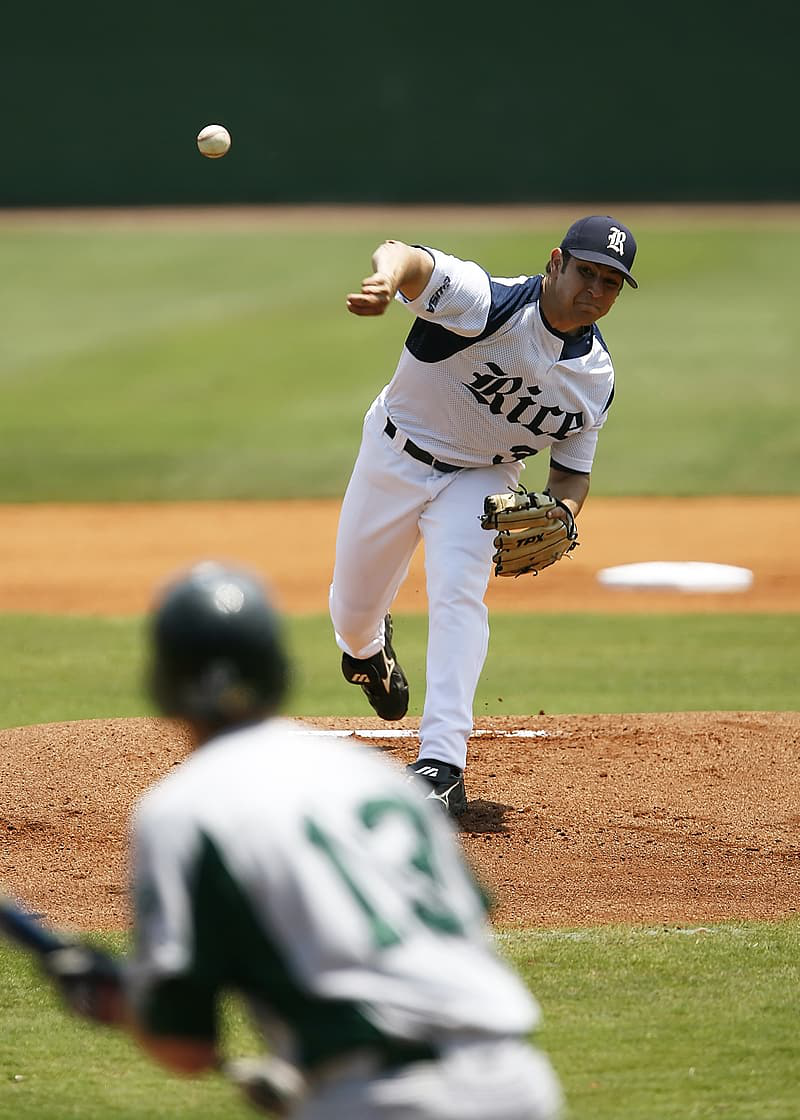

In [ ]:
def load_to_np_string(image_path):
    with open(image_path, 'rb') as f:
        np_image_string = np.array([f.read()])
    image = Image.open(image_path)
    width, height = image.size
    np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)
    return height, width, image, np_image, np_image_string

!wget -q -O test.jpg https://p0.pikrepo.com/preview/342/372/baseball-players-on-field-during-daytime.jpg

image_path = 'test.jpg'
height, width, image, np_image, np_image_string = load_to_np_string(image_path)
image

## Create a Tensorflow session
Now let us create a Tensorflow session to run the inference. You can either connect to a TPU or a normal CPU backend.

In [ ]:
session = tf.compat.v1.Session(graph=tf.Graph())

# Load the pretrained model
Loading the COCO pretrained saved model from the public GCS bucket. 

In [ ]:
saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850'
_ = tf.compat.v1.saved_model.loader.load(session, ['serve'], saved_model_dir)

INFO:tensorflow:Restoring parameters from gs://cloud-tpu-checkpoints/mask-rcnn/1555659850/variables/variables


## Perform instance segmentation and retrieve the predictions
Now let's run the inference and process the predictions from the model.


In [ ]:
def mask_rcnn(np_image_string):
    num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
        ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
        feed_dict={'Placeholder:0': np_image_string})

    num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
    detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
    detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
    detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
    instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
    ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
    processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
    segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)
    return (num_detections, detection_boxes, detection_scores, detection_classes, instance_masks,
            ymin, xmin, ymax, xmax, processed_boxes, segmentations)

(num_detections, detection_boxes, detection_scores, detection_classes,
 instance_masks, ymin, xmin, ymax, xmax, processed_boxes, segmentations) = mask_rcnn(np_image_string)

## Visualize the detection results
Time to check out the result!

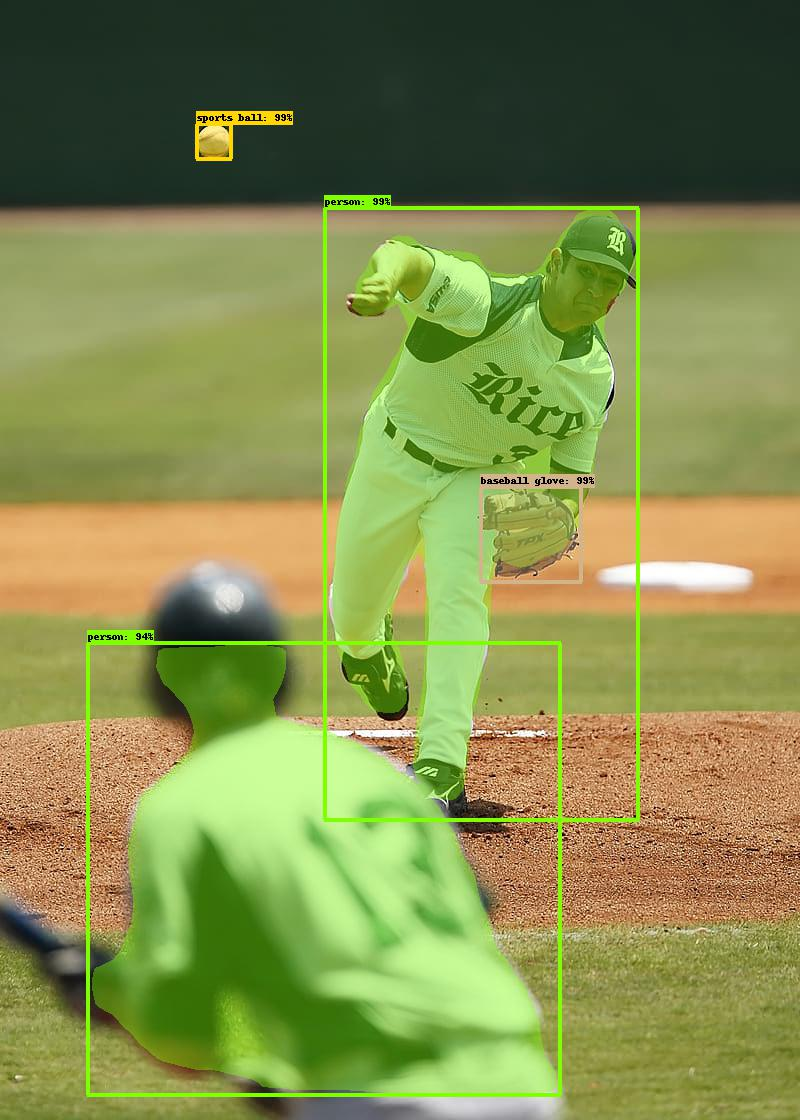

In [ ]:
max_boxes_to_draw = 50   #@param {type:"integer"}
min_score_thresh = 0.5    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)

output_image_path = 'test_results.jpg'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
display.display(display.Image(output_image_path, width=1024))

# Separating a segmented instance of the image for stylization

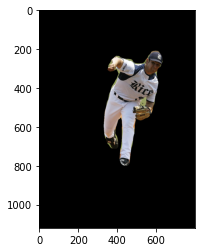

In [ ]:
image = np.asarray(image)
mask = segmentations[0]
mask = np.array([mask, mask, mask])
mask = np.moveaxis(mask, 0, -1)
masked = image * mask
masked = Image.fromarray(masked)
masked.save('masked.png')

%matplotlib inline
plt.imshow(masked)
plt.show()

In [ ]:
# Standard library imports
import os
import time
import random

# 3rd party imports
import IPython.display
from tensorflow.keras import models 
from tensorflow.keras import losses
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_file
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
# Create the ./style/ directory
style_imgs_dir = './style/'
if not os.path.exists(style_imgs_dir):
    os.makedirs(style_imgs_dir)

# Download the test images in the ./style/ directory
!wget -q -O $style_imgs_dir/starry.jpg https://upload.wikimedia.org/wikipedia/commons/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

In [ ]:
def load_to_batch(path):
    """Loads an image and returns it in a batch.
    
    Loads the image located in path, resizes it and returns a batch
    containing the image. The image is resized such that its largest
    dimension (width or height) is size 512, while keeping the original
    aspect ratio.
    
    Arguments:
        path: The location of the image to read.

    Returns:
        A numpy array of size (1, w, h, n), where w and h
        are the dimensions of the image after resizing it
        and n is the number of channels in the image.
    """
    # Read and resize the image
    max_dim = 512
    img = Image.open(path)
    long_dim = max(img.size)
    scale = max_dim/long_dim
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)),
                     Image.ANTIALIAS)
    img = img_to_array(img)
    # Include the resized image within a batch
    img = np.expand_dims(img, axis=0)
    return img.astype('uint8')

def imshow(img, title=None):
    """Display an image using matplotlib.
    
    Arguments:
        img: The image to display.
        title (optional): Title to display.
    """
    # Remove the first dimension so that only an image is kept
    # and no longer a batch of an image.
    out = np.squeeze(img, axis=0)
    # Display the image
    out = out.astype('uint8')
    plt.imshow(out)
    plt.axis('off')
    if title:
        plt.title(title)

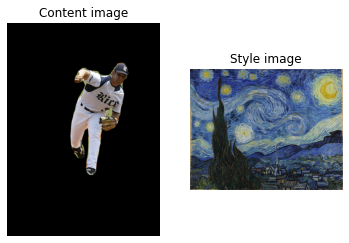

In [ ]:
style_path = './style/starry.jpg'
content_path = 'masked.png'

# Read the images
style_img = load_to_batch(style_path)
content_img = load_to_batch(content_path)

# Display the images
plt.subplot(1, 2, 1)
imshow(content_img, 'Content image')
plt.subplot(1, 2, 2)
imshow(style_img, 'Style image')

# Save figure
plt.savefig('src_starry_test.png', bbox_inches='tight')

In [ ]:
def load_and_process(path):
    """Preprocess an image.
    
    Load the image located in path, resize it and
    obtain a batch containing the image. Then, preprocess
    the batch according to the VGG19 network requirements.

    Arguments:
        path: The path to the image to be preprocessed.

    Returns:
    A preprocessed numpy array of size (1, w, h, n), where w and h
    are the dimensions of the image after resizing and n is the number
    of channels in the image.
    """
    img = load_to_batch(path)
    img = vgg19.preprocess_input(img)
    return img

In [ ]:
def deprocess_img(processed_img):
    """Applies the reverse process of the load_and_process function.
    
    Arguments:
        processed_img: an image processed by load_and_process.
                       It can have size (1, h, w, n) or (h, w, n).

    Returns:
        The deprocessed image in a numpy array of type uint8.
    """
    x = processed_img.copy()
    # First make sure that the image has
    # the correct dimensions
    if x.ndim == 4:
        x = np.squeeze(x, 0)
    assert x.ndim == 3, ('Input to deprocess image must '
                         'be an image of shape '
                         '[1, height, width, channel] '
                         'or [height, width, channel]')
    # Perform deprocessing
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    # The deprocessed image must be of type uint8
    # so it takes values between 0 and 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
# The layer used to obtain the content of an image
content_layers = ['block5_conv2']

# Layers used to obtain the style of an image
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1',
                'block5_conv1']

# Auxiliary constants
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def get_model():
    """Creates the VGG19 model with access to the desired intermediate layers.

    Returns:
        A Keras model that accepts as input an image and returns
        the feature volumes generated in the style and content layers.
    """

    # Load the VGG19 network, trained with ImageNet
    # Do not include the dense part of the network
    vgg = vgg19.VGG19(include_top=False)
    vgg.trainable = False

    # Define the outputs of the model
    style_outputs = [vgg.get_layer(name).output 
                     for name in style_layers]
    content_outputs = [vgg.get_layer(name).output 
                       for name in content_layers]
    model_outputs = style_outputs + content_outputs
    
    # Return the model
    return models.Model(vgg.input, model_outputs)

In [ ]:
def get_content_loss(base_content, target):
    """Calculates the loss of content, given the
    content representations of the target image
    and the base image.
    
    Arguments:
        base_content: Content representation of the base image.
        target: Content representation of the target image.
    Returns:
        The content loss. It is calculated using the mean
        instead of simply the sum.
    """
    return tf.reduce_mean(tf.square(base_content - target))

In [ ]:
def gram_matrix(input_tensor):
    """Calculates the Gram matrix of a feature volume.
    
    Arguments:
        input_tensor: The feature volume generated by the network
                      when receiving as input an image
    Returns:
        The calculated Gram matrix.
    """
    # The number of image channels
    channels = int(input_tensor.shape[-1])
    # Vectorize the feature maps
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    # Gram's matrix is calculated as all the possible correlations
    # between the possible correlations between the vectorized
    # vectorized feature maps.
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

In [ ]:
def get_style_loss(base_style, gram_target):
    """Calculates the style loss.

    Arguments:
        base_style: A feature volume generated with the style image.
        gram_target: A Gram array of the target image.

    Returns:
        The calculated style loss.
    """
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    # In this case, the normalization term is omitted.
    return tf.reduce_mean(tf.square(gram_style - gram_target))
    # / (4. * (channels ** 2) * (width * height) ** 2)

In [ ]:
def get_feature_representations(model, content_path, style_path):
    """Calculates the desired style and content feature volumes.
    
    Loads and preprocesses the style and content images, delivers them
    to the network, and obtains the outputs from the intermediate
    network layers defined for the style and content.

    Arguments:
        model: The model (network) from which the representations are obtained.
        content_path: The location of the content image.
        style_path: The location of the style image.

    Returns:
        The style and content feature volumes that you want to combine.
    """
    # Load the images
    content_image = load_and_process(content_path)
    style_image = load_and_process(style_path)

    # Obtain the feature volumes of interest
    style_outputs = model(style_image)
    content_outputs = model(content_image)


    # Extract style and content feature volumes
    style_features = [style_layer[0] 
                      for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] 
                        for content_layer 
                        in content_outputs[num_style_layers:]]
    return style_features, content_features

In [ ]:
def compute_loss(model, loss_weights, init_image,
                 gram_style_features, content_features):
    """Computes the total loss.

    Arguments:
        model: The model with access to intermediate layers.
        loss_weights: The weights of the contributions of the
                      style and content losses to the total loss.
        init_image: The base x image to be modified so that it minimizes
                    the total loss.
        gram_style_features: The gram matrices of the style layers defined above.
                             defined above.
        content_features: The feature volumes obtained in the content layers.
                          content_features.
        
    Returns:
        The total loss, style loss, and content loss.
    """

    style_weight, content_weight = loss_weights

    # The image is passed through the network to obtain the
    # style and content feature volumes.
    model_outputs = model(init_image)
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    # For each style layer, accumulate its contribution
    # to the total style loss. In this case, it was decided
    # that the contribution of each style layer be the same.
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features,
                                        style_output_features):
        style_score += (weight_per_style_layer
                        * get_style_loss(comb_style[0],
                                         target_style))

    # For each content layer, accumulate its contribution
    # to the total content loss.
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, 
                                            content_output_features):
        content_score += (weight_per_content_layer
                          * get_content_loss(comb_content[0],
                                             target_content))

    # Each partial loss is multiplied by its respective weight.
    style_score *= style_weight
    content_score *= content_weight

    # Calculate the total loss
    loss = style_score + content_score

    # Return losses
    return loss, style_score, content_score

In [ ]:
def compute_grads(cfg):
    # Calcula losses
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    # Obtain the total loss
    total_loss = all_loss[0]
    # Calculate the gradients with respect to the combined image x
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [ ]:
def path_to_name(path):
    path = path.split('.')[-2]
    path = path.split('/')[-1]
    return path

In [ ]:
def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2,
                       save_as=None):
    # The model is loaded. It must be specified that
    # it is not going to be trained.
    model = get_model() 
    for layer in model.layers:
        layer.trainable = False
    
    # Get the content and style feature volumes
    (style_features,
     content_features) = get_feature_representations(model,
                                                     content_path,
                                                     style_path)

    # Calculate the style representations
    gram_style_features = [gram_matrix(style_feature)
                           for style_feature
                           in style_features]
    
    # Create the initial image, which is the same as the content image.
    init_image = load_and_process(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)

    # Initialize the optimizer
    opt = Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

    # Iteration counter
    iter_count = 1
    
    # Save the best loss and the image that generates that loss
    best_loss, best_img = float('inf'), None
    
    # Dictionary containing the entries of the
    # compute_loss function
    loss_weights = (style_weight, content_weight)
    cfg = {'model': model,
           'loss_weights': loss_weights,
           'init_image': init_image,
           'gram_style_features': gram_style_features,
           'content_features': content_features}
        
    # Setting up auxiliary variables to display the results
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations/(num_rows*num_cols)
    start_time = time.time()
    global_start = time.time()
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means     
    
    # List to save images generated in certain iterations
    imgs = []
    # Lists for saving loss history
    loss_history = []
    style_loss_history = []
    content_loss_history = []

    # Main loop
    for i in range(num_iterations):
        # Compute the gradients and losses
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        # Save them in the record
        loss_history.append(loss)
        style_loss_history.append(style_score)
        content_loss_history.append(content_score)
        # Apply optimization to the image
        opt.apply_gradients([(grads, init_image)])
        # The generated image must have its values within the valid range
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time() 
        
        # If the new loss is less than the best loss
        if loss < best_loss:
            # Upgrade the best image and the best loss
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        # Every few intervals the partial results are displayed
        if i % display_interval== 0:
            start_time = time.time()
            
            # The image is deprocessed to be displayed
            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append((i, plot_img))
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Iteration: {}'.format(i))                
            print(f'Total loss: {loss:.4e}, ' 
                  f'style loss: {style_score:.4e}, '
                  f'content loss: {content_score:.4e}, '
                  f'time: {time.time() - start_time:.4f}s')
    
    # Display the total optimization time
    print('Total time: {:.4f}s'.format(time.time() - global_start))

    # Loss history is displayed
    plt.figure(figsize=(5, 3.5))
    plt.plot(loss_history, label='total')
    plt.plot(style_loss_history, label='style')
    plt.plot(content_loss_history, label='content')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(f'{path_to_name(content_path)}_{path_to_name(style_path)}_loss.png')

    # All partial results are displayed
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    for i, (iteration, img) in enumerate(imgs):
            plt.subplot(num_rows,num_cols,i+1)
            plt.imshow(img)
            plt.title(f'Iteration {iteration}')
            plt.axis('off')
            if save_as is not None:
                    plt.savefig(save_as)

    return best_img, best_loss

In [ ]:
def show_results(best_img, content_path, style_path,
                 show_large_final=True, save_as=None):
    plt.figure(figsize=(10, 5))
    content = load_to_batch(content_path) 
    style = load_to_batch(style_path)

    plt.subplot(1, 2, 1)
    imshow(content, 'Content Image')

    plt.subplot(1, 2, 2)
    imshow(style, 'Style Image')

    if show_large_final: 
        plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.axis('off')
    
    if save_as is not None:
        plt.savefig(save_as)

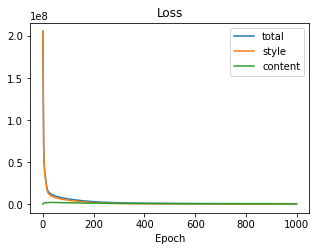

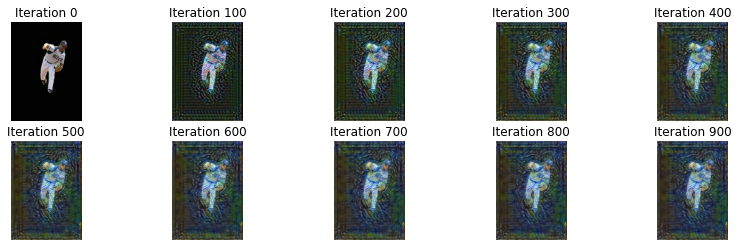

In [ ]:
style_path = 'style/starry.jpg'
content_path = 'masked.png'

best, best_loss = run_style_transfer(content_path,
                                     style_path,
                                     num_iterations=1000,
                                     save_as='stylization.png')

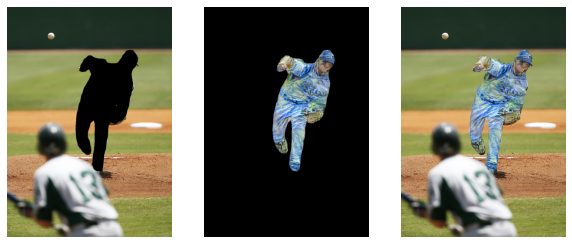

In [ ]:
best_img = Image.fromarray(best).resize((width, height))

background = image * np.logical_not(mask)
foreground = best_img * mask
total = background + foreground

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(background)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(foreground)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(total)
plt.axis('off');

In [ ]:
Image.fromarray(foreground).save('stylized_segment.png')
Image.fromarray(total).save('stylized_segment_on_bg.png')

In [ ]:
# Create the ./style/ directory
style_imgs_dir = './style/'
if not os.path.exists(style_imgs_dir):
    os.makedirs(style_imgs_dir)

# Download the style images to the ./style/ directory.
!wget -q -O $style_imgs_dir/1.png https://upload.wikimedia.org/wikipedia/commons/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
!wget -q -O $style_imgs_dir/2.png https://img.theculturetrip.com/1024x/smart/wp-content/uploads/2017/10/monet_water_lilies_1916.jpg
!wget -q -O $style_imgs_dir/3.png https://upload.wikimedia.org/wikipedia/commons/thumb/6/66/Johannes_Vermeer_%281632-1675%29_-_The_Girl_With_The_Pearl_Earring_%281665%29.jpg/1200px-Johannes_Vermeer_%281632-1675%29_-_The_Girl_With_The_Pearl_Earring_%281665%29.jpg
!wget -q -O $style_imgs_dir/4.png https://www.vangoghstudio.com//Files/6/102000/102147/ProductPhotos/Source/1231095862.jpg

style_imgs_paths = [os.path.join(style_imgs_dir, style_img)
                    for style_img in os.listdir(style_imgs_dir)]

In [ ]:
# !wget -q -O test.jpg https://p0.pikrepo.com/preview/342/372/baseball-players-on-field-during-daytime.jpg
!wget -q -O test.jpg https://upload.wikimedia.org/wikipedia/commons/0/0c/Mark_Sanford_%28basketball%29_02.jpg
# !wget -q -O test.jpg https://i.pinimg.com/474x/ed/89/47/ed8947fe0834327f61985a312f094210.jpg

image_path = 'test.jpg'
height, width, image, np_image, np_image_string = load_to_np_string(image_path)

(num_detections, detection_boxes, detection_scores, detection_classes,
 instance_masks, ymin, xmin, ymax, xmax, processed_boxes, segmentations) = mask_rcnn(np_image_string)

image = np.asarray(image)

In [ ]:
valid_detections = (detection_scores > 0.5) & (detection_classes == 1)
valid_segmentations = segmentations[valid_detections]

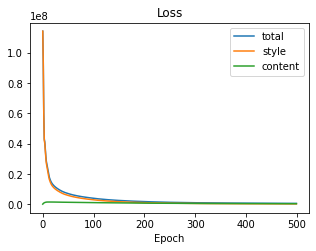

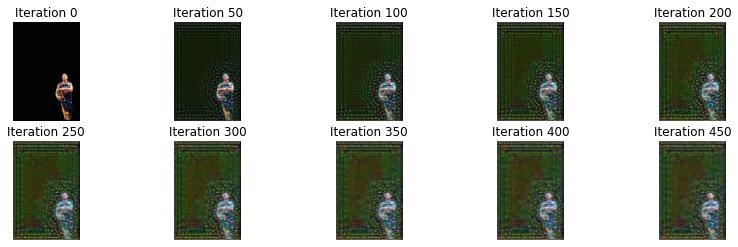

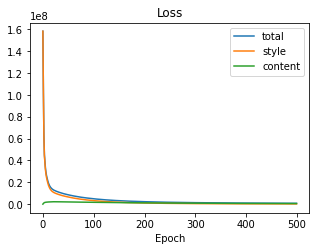

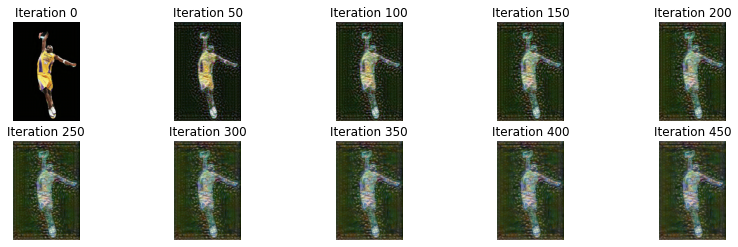

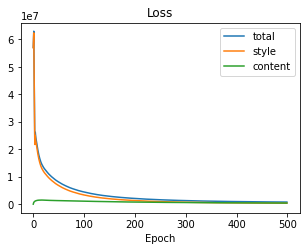

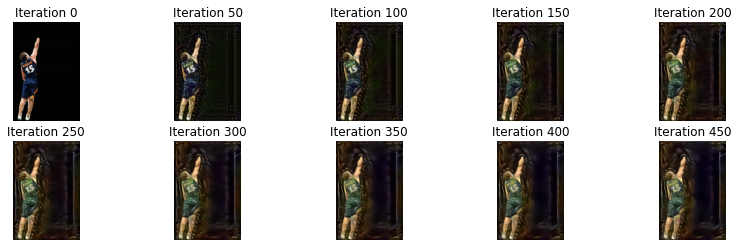

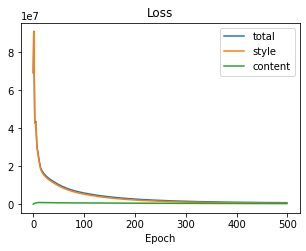

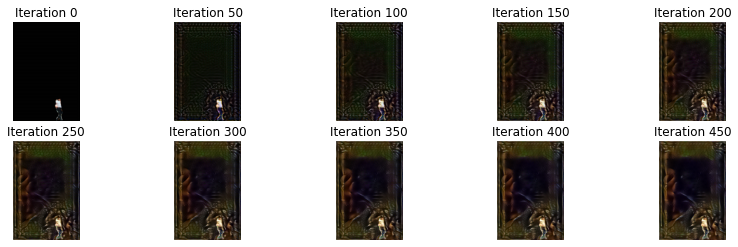

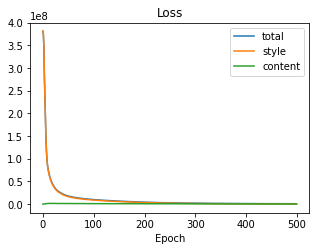

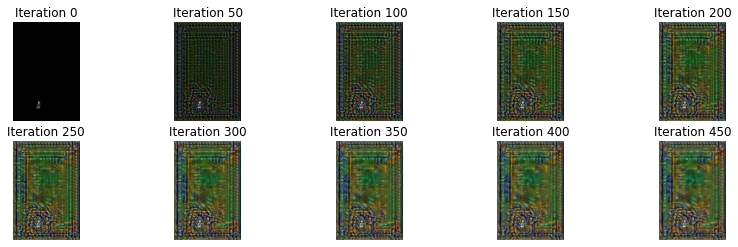

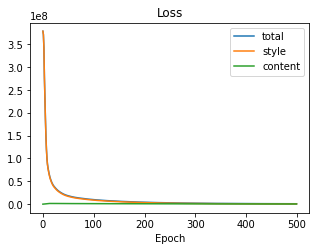

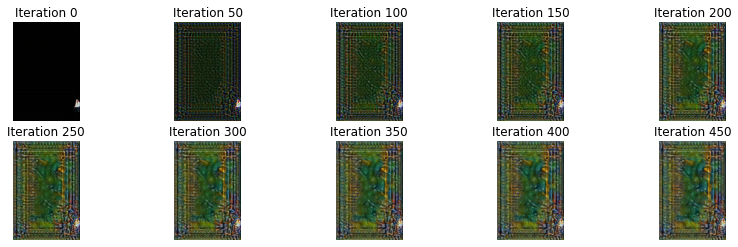

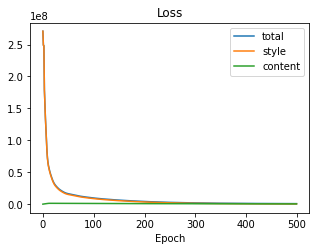

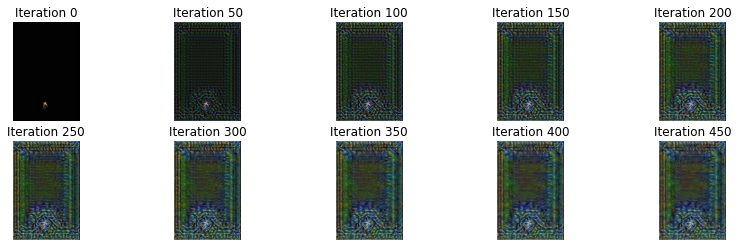

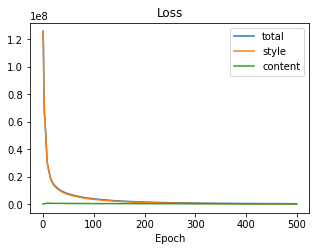

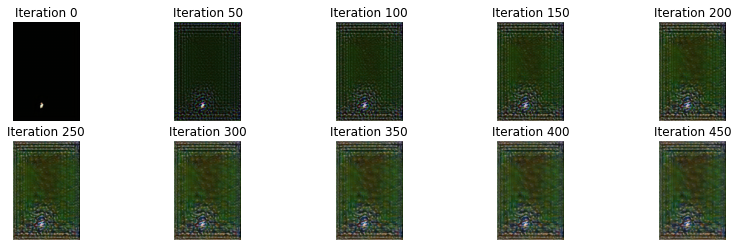

In [ ]:
result = image.copy()
style_imgs = random.choices(style_imgs_paths, k=len(valid_segmentations))

stylized_segments = []
for segmentation, style_path in zip(valid_segmentations, style_imgs):
    mask = segmentation
    mask = np.array([mask, mask, mask])
    mask = np.moveaxis(mask, 0, -1)
    result *= np.logical_not(mask)
    masked = image * mask
    masked = Image.fromarray(masked)
    content_path = 'masked.png'
    masked.save(content_path)
    best, _ = run_style_transfer(content_path,
                                 style_path,
                                 num_iterations=500)
    best = Image.fromarray(best)
    best = best.resize((width, height))
    stylized_segments.append(best)

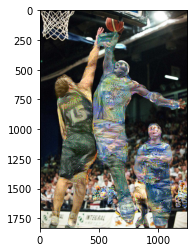

In [ ]:
final = result

for i, (stylized_segment, mask) in enumerate(zip(stylized_segments,
                                                 valid_segmentations)):
    stylized_segment.save(f'stylized_segment_{i}.png')
    mask = np.array([mask, mask, mask])
    mask = np.moveaxis(mask, 0, -1)
    final += mask * stylized_segment

plt.imshow(final)
Image.fromarray(final).save('total.png')